# NLP tf-idf pipeline with scikit-learn

In [1]:
%matplotlib inline
from tqdm import tqdm
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import pandas as pd

In [2]:
# Import other utility functions for benhmarking purposes 
from utils import SimpleTimer, ResultsLogger, visualize_data

## Benchmarking Code

### Helper functions

In [3]:
nltk.download('stopwords')
STOPWORDS = set(nltk.corpus.stopwords.words('english')) # converting the list to set will decrease latency in the pandas apply function: O(1) lookup
PUNCTUATIONS = ['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.',
                '/', '\\', ':', ';', '<', '=', '>', '?', '@', '[', ']', '^',
                '_', '`', '{', '|', '}', '\t','\n', "'", ",", '~' , '—']

def read_data(parquet_path):
    data = pd.read_parquet(parquet_path)
    return data


def text_preprocessor(data, column_name, PUNCTUATIONS, STOPWORDS):
    data = data[data[column_name].notna()]
    # from https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas
    transtable = str.maketrans(dict.fromkeys("".join(PUNCTUATIONS), ''))
    data.loc[:,column_name] = (data[column_name].str.lower()
                           .str.translate(transtable)
                           .str.strip())
    data.loc[:,column_name] = data[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS]))                    
    return data


def hashing_vectorizer(data, column_name):
    vectorizer = HashingVectorizer(stop_words=None, preprocessor=None)
    hashing_vectorized = vectorizer.fit_transform(data[column_name])
    return hashing_vectorized


def tfidf_transformer(hashing_vectorized, column_name):
    transformer = TfidfTransformer()
    result = transformer.fit_transform(hashing_vectorized)
    return result


def execute_full_pipeline(n, i, parquet_path):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(parquet_path)
    sample_record["data_read"]=timer.elapsed/1e9

    with SimpleTimer() as timer:
        data = text_preprocessor(data, "review_body", PUNCTUATIONS, STOPWORDS)
    sample_record["data_preprocessing"]=timer.elapsed/1e9

    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data,"review_body")
    sample_record["hashing_vectorizer"]=timer.elapsed/1e9

    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, "review_body")
    sample_record["tfidf_transformer"]=timer.elapsed/1e9

    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, result, sample_record


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def performance_numbers(parquet_path, worker_counts=[1], samples=1, result_path="./results.csv"):
    """
    Main function to perform the performance sweep
    """
    results_logger = ResultsLogger(result_path)
    for n in worker_counts: 
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i, parquet_path)
            sample_record["overall"]=overalltimer.elapsed/1e9
            sample_record["nrows"]=data.shape[0]
            sample_record["n_workers"]=n
            sample_record["sample_run"]=i
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed/1e9}s")
            results_logger.log(sample_record)
    results_logger.write()

In [5]:
dataset = "Books"
parquet_path = f'./data/product_category={dataset}'
samples = 2
worker_counts = [1]
result_path = f"./results/result_poc_nlp_sklearn_{dataset}.csv"

In [6]:
%%time
performance_numbers(parquet_path=parquet_path, worker_counts=worker_counts, samples=samples,result_path=result_path)

  0%|                                                                                                                                                                                      | 0/2 [00:00<?, ?it/s]/home/nfs/anirband/anaconda3/envs/rapids-21.08/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Workers:1, Sample Run:0, Finished loading data in 70.212867167s
Workers:1, Sample Run:0, Finished preprocessing data in 1267.27143621s
Workers:1, Sample Run:0, Finished fitting HashVectorizer in 733.616369119s
Workers:1, Sample Run:0, Finished fitting IDF Transformer in 72.356304989s


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1/2 [35:43<35:43, 2143.74s/it]

Workers:1, Sample Run:0, Finished executing full pipeline in 2143.740205188s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [1:12:42<00:00, 2181.10s/it]

Workers:1, Sample Run:1, Finished loading data in 73.225085344s
Workers:1, Sample Run:1, Finished preprocessing data in 1278.299065036s
Workers:1, Sample Run:1, Finished fitting HashVectorizer in 738.666063173s
Workers:1, Sample Run:1, Finished fitting IDF Transformer in 127.988551732s
Workers:1, Sample Run:1, Finished executing full pipeline in 2218.46432265s


CPU times: user 1h 11min 12s, sys: 9min 45s, total: 1h 20min 57s
Wall time: 1h 13min 4s


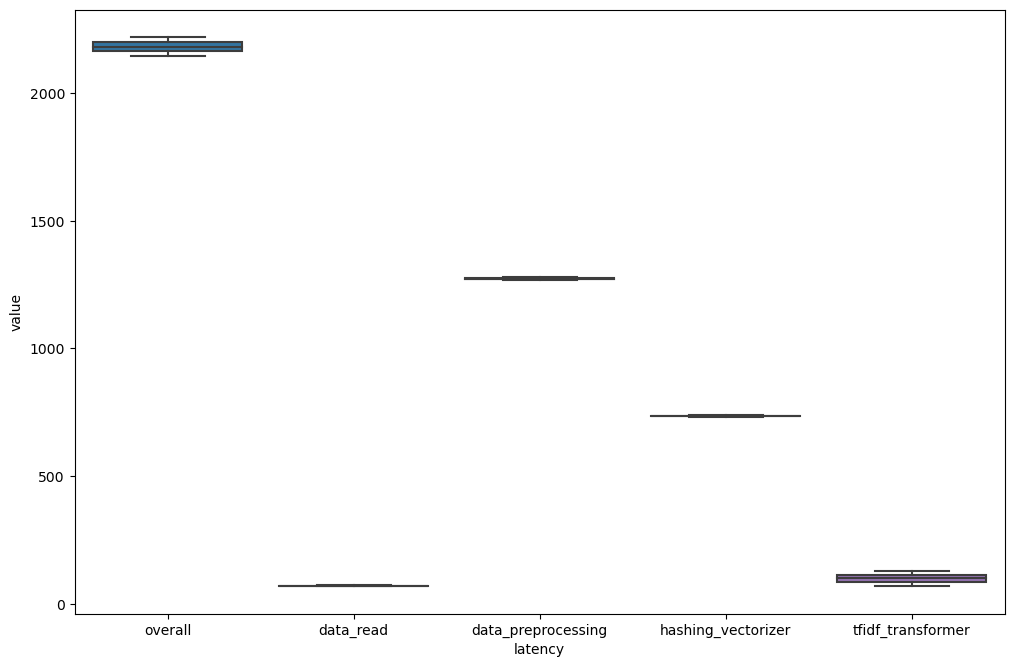

In [7]:
data, melt_data = visualize_data(result_path)    

In [8]:
data

,Unnamed: 0,overall,data_read,hashing_vectorizer,tfid_transformer,data_preprocessing,nrows,tfidf_transformer,n_workers,sample_run
0,0,2143.740205,70.212867,733.616369,0,1267.271436,20725971,72.356305,1,0
1,1,2218.464323,73.225085,738.666063,0,1278.299065,20725971,127.988552,1,1


In [9]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [10]:
groupy

Unnamed: 0                      overall                  data_read  \
                mean       std count         mean       std count       mean   
n_workers                                                                      
1                0.5  0.707107     2  2181.102264  52.83793     2  71.718976   

                         hashing_vectorizer  ... data_preprocessing     nrows  \
               std count               mean  ...              count      mean   
n_workers                                    ...                                
1          2.12996     2         736.141216  ...                  2  20725971   

                     tfidf_transformer                  sample_run            \
           std count              mean        std count       mean       std   
n_workers                                                                      
1          0.0     2        100.172428  39.337939     2        0.5  0.707107   

                 
          count  
n_workers        
1             2  

[1 rows x 27 columns]